In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from VQE import VQE
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from utils import *
from qiskit import IBMQ, Aer
from qiskit.circuit.library import EfficientSU2
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from GroupingAlgorithm import grouping, groupingWithOrder
from HEEM_VQE_Functions import *
from qiskit.circuit.random import random_circuit


In [2]:
IBMQ.load_account()
provider      = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic') 
backend_exp   = provider.get_backend('ibmq_guadalupe')
WC_exp        = get_backend_connectivity(backend_exp)

In [3]:
backend_sim = Aer.get_backend('aer_simulator')
# backend_sim = AerSimulator.from_backend(backend_exp)
shots = 2**13

In [4]:
ExpVal_theo = []
ExpVal_TPB  = []
ExpVal_EM   = []
ExpVal_HEEM = []

MC = 100
num_qubits = 10

for k in range( MC ) :

    H = RandomHamiltonian( num_qubits, num_qubits**2 )

    ###
    paulis, coeff, labels = Label2Chain( H )
    Color, Groups, Measurements = TPBgrouping( paulis )
    prob2Exp = probability2expected( coeff, labels, Groups, Measurements)
    circuits = [ measure_circuit_factor( measure , num_qubits )[0] for measure in Measurements ]
    counts = backend_sim.run( circuits, shots=shots ).result().get_counts()
    probs = [ post_process_results( count, num_qubits, shots ) for count in counts ]
    ExpVal = 0
    for j in range(len(probs)):
        ExpVal += np.sum(prob2Exp[j]@probs[j])
    ExpVal_TPB.append( ExpVal )
    ###
    paulis, coeff, labels = Label2Chain( H )
    Groups, Measurements, T = groupingWithOrder( paulis )
    prob2Exp = probability2expected( coeff, labels, Groups, Measurements)
    circuits = [ measure_circuit_factor( measure , num_qubits )[0] for measure in Measurements ]
    counts = backend_sim.run( circuits, shots=shots ).result().get_counts()
    probs = [ post_process_results( count, num_qubits, shots ) for count in counts ]
    ExpVal = 0
    for j in range(len(probs)):
        ExpVal += np.sum(prob2Exp[j]@probs[j])
    ExpVal_EM.append( ExpVal )
    ####
    paulis, coeff, labels = Label2Chain( H )
    Groups, Measurements, T = groupingWithOrder( paulis, G = WC_exp )
    prob2Exp = probability2expected( coeff, labels, Groups, Measurements)
    circuits = [ measure_circuit_factor( measure , num_qubits )[0] for measure in Measurements ]
    counts = backend_sim.run( circuits, shots=shots ).result().get_counts()
    probs = [ post_process_results( count, num_qubits, shots ) for count in counts ]
    ExpVal = 0
    for j in range(len(probs)):
        ExpVal += np.sum(prob2Exp[j]@probs[j])
    ExpVal_HEEM.append( ExpVal )
    ####

    ExpVal_theo.append( H.to_matrix()[0,0] )

In [5]:
ExpVal_theo = np.array(ExpVal_theo)
ExpVal_TPB  = np.array(ExpVal_TPB)
ExpVal_EM   = np.array(ExpVal_EM)
ExpVal_HEEM = np.array(ExpVal_HEEM)
mean= [ np.mean( np.abs(ExpVal_theo-ExpVal_TPB) ), np.mean( np.abs(ExpVal_theo-ExpVal_EM) ), np.mean( np.abs( ExpVal_theo- ExpVal_HEEM) ) ]
std = [ np.std( np.abs(ExpVal_theo-ExpVal_TPB) ), np.std( np.abs(ExpVal_theo-ExpVal_EM) ), np.std( np.abs( ExpVal_theo- ExpVal_HEEM) ) ]
mean, std

([0.091162109375, 0.08510498046875, 0.0946728515625],
 [0.06616960433793241, 0.05754329891108822, 0.060492091639335756])

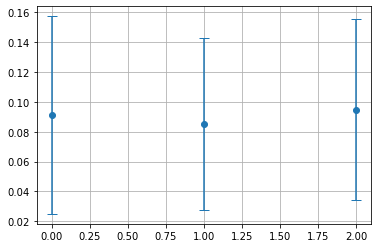

In [6]:
plt.errorbar( [0,1,2], mean, std, capsize=5, fmt='o' )
plt.grid()
